In [85]:
# Importing Important libraries 

# For data cleaning and visualization
import math
import pandas as pd
import numpy as np
from numpy import array
from datetime import date, datetime, timedelta


# For model
from numpy import newaxis
import keras
from keras import optimizers, callbacks
from keras.layers import InputLayer, Input, Masking, Dense, Activation, Dropout, LSTM
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers, callbacks

# For saving the model
import pickle

# For Prediction 
from numpy import newaxis

# For model Evaluation
from sklearn import metrics
from sklearn.metrics import mean_squared_error

# For Plotting 
import matplotlib.pyplot as plt
from pylab import rcParams 

In [86]:
def create_windows(data, data_len, sequence_len=10):
  data_windows = []
  for i in range(data_len - sequence_len):
    data_windows.append(data[i : i+sequence_len])

  # set the type of training data     
  data_windows = np.array(data_windows).astype(float)
  return (data_windows)

In [87]:
def Normalize_data(data_windows):
  # number of windows formed 
  windows_no = data_windows.shape[0]
  cols_no = data_windows.shape[2]

  # initializing list to store normalized data
  normalized_data = []
  record_min=[]
  record_max=[]

  # normalizing begins
  for win_index in range(windows_no):
    normalized_window = []

    for col_index in range(0,1):
      # temporary column 
      t_col = data_windows[win_index, :, col_index]
      t_min = min(t_col)
      if (col_index == 0):
        record_min.append(t_min)
      t_col = t_col - t_min      
      t_max = max(t_col)
      if (col_index == 0):
        record_max.append(t_max)
      t_col = t_col/t_max
      normalized_window.append(t_col)
    
    for col_index in range(1,  cols_no):
      t_col = data_windows[win_index, :, col_index]
      normalized_window.append(t_col)

    normalized_window = np.array(normalized_window).T
    normalized_data.append(normalized_window)

  normalized_data=np.array(normalized_data)
  return (normalized_data, record_max, record_min)


In [88]:
def plot_training_loss(model_hist):
  # plotting the lose curve during model training
  plt.plot(model_hist.history['loss'])
  plt.title('Training Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['train'],loc='upper left')
  plt.show()


In [89]:
def Model_Evaluation(actual_prices, predicted_prices):
  # Mean Absolute Error 
  MAE = metrics.mean_absolute_error(actual_prices, predicted_prices)
  # Mean Squared Error
  MSE = metrics.mean_squared_error(actual_prices, predicted_prices)
  # Root Mean Squared Error
  RMSE = np.sqrt(metrics.mean_squared_error(actual_prices, predicted_prices))

  # Mean Absolute Percentage Error in degrees
  errors = abs(actual_prices - predicted_prices)
  MAPE = 100 * (errors /actual_prices)

  # Model Accuracy
  Accuracy = 100 - np.mean(MAPE)
  return (Accuracy, MAE, MSE, RMSE)

In [90]:
def DP_LSTM(df):
  # Adding noise to dataset
  # calculating the variance of the mean_compound column
  wsj_var=np.var(df.wsj_mean_compound)
  cnbc_var=np.var(df.cnbc_mean_compound)
  fortune_var=np.var(df.fortune_mean_compound)
  reuters_var=np.var(df.reuters_mean_compound)

  mu=0
  noise=0.1
  sigma_wsj=noise*wsj_var
  sigma_cnbc=noise*cnbc_var
  sigma_fortune=noise*fortune_var
  sigma_reuters=noise*reuters_var

  n=df.shape[0]
  df_noise=pd.DataFrame()
  df_noise['wsj_noise']=df['wsj_mean_compound']
  df_noise['cnbc_noise']=df['cnbc_mean_compound']
  df_noise['fortune_noise']=df['fortune_mean_compound']
  df_noise['reuters_noise']=df['reuters_mean_compound']

  for i in range(0,n):
    df_noise['wsj_noise'][i]+=np.random.normal(mu,sigma_wsj)
    df_noise['cnbc_noise'][i]+=np.random.normal(mu,sigma_cnbc)
    df_noise['fortune_noise'][i]+=np.random.normal(mu,sigma_fortune)
    df_noise['reuters_noise'][i]+=np.random.normal(mu,sigma_reuters)

  df_noise.to_csv("source_price_noise0.csv")
  dfn=pd.read_csv("source_price_noise0.csv",index_col=0)  

  df_1n=pd.DataFrame()
  df_1n['wsj']=dfn['wsj_noise']
  df_1n['cnbc']=df['cnbc_mean_compound']
  df_1n['fortune']=df['fortune_mean_compound']
  df_1n['reuters']=df['reuters_mean_compound']
  df_1n['price']=df['Adj Close']

  df_2n=pd.DataFrame()
  df_2n['wsj']=df['wsj_mean_compound']
  df_2n['cnbc']=dfn['cnbc_noise']
  df_2n['fortune']=df['fortune_mean_compound']
  df_2n['reuters']=df['reuters_mean_compound']
  df_2n['price']=df['Adj Close']

  df_3n=pd.DataFrame()
  df_3n['wsj']=df['wsj_mean_compound']
  df_3n['cnbc']=df['cnbc_mean_compound']
  df_3n['fortune']=dfn['fortune_noise']
  df_3n['reuters']=df['reuters_mean_compound']
  df_3n['price']=df['Adj Close']

  df_4n=pd.DataFrame()
  df_4n['wsj']=df['wsj_mean_compound']
  df_4n['cnbc']=df['cnbc_mean_compound']
  df_4n['fortune']=df['fortune_mean_compound']
  df_4n['reuters']=dfn['reuters_noise']
  df_4n['price']=df['Adj Close']

  df1=df_1n
  df2=df_2n
  df3=df_3n
  df4=df_4n

  sequence_length=10;
  split = 0.85
  i_split = int(len(df1) * split)
  i_split  

  # choosing columns for the model
  cols = ['price','wsj','cnbc','fortune','reuters']
  data_train1 = df1.get(cols).values[:i_split]
  data_train2 = df2.get(cols).values[:i_split]
  data_train3 = df3.get(cols).values[:i_split]
  data_train4 = df4.get(cols).values[:i_split]
  train_len  = len(data_train1)
  train_windows_len = None


  # Normalizing Train data1
  data_windows1 = create_windows(data_train1,train_len,sequence_length)
  normalized_data1,rmax_t1, rmin_t1 = Normalize_data(data_windows1)


  x_train1 = normalized_data1[:, :-1]
  y_train1 = normalized_data1[:, -1,[0]]

  # Normalizing Train data2
  data_windows2 = create_windows(data_train2, train_len,sequence_length)
  normalized_data2,rmax_t2, rmin_t2 = Normalize_data(data_windows2)

  x_train2 = normalized_data2[:, :-1]
  y_train2 = normalized_data2[:, -1,[0]]

  # Normalizing Train data3
  data_windows3 = create_windows(data_train3, train_len,sequence_length)
  normalized_data3,rmax_t3, rmin_t3 = Normalize_data(data_windows3)

  x_train3 = normalized_data3[:, :-1]
  y_train3 = normalized_data3[:, -1,[0]]

  # Normalizing Train data4
  data_windows4 = create_windows(data_train4, train_len,sequence_length)
  normalized_data4,rmax_t4, rmin_t4 = Normalize_data(data_windows4)

  x_train4 = normalized_data4[:, :-1]
  y_train4 = normalized_data4[:, -1,[0]]

  # concatenating the training data
  x_train = np.concatenate((x_train1,x_train2, x_train3, x_train4),axis=0)
  y_train = np.concatenate((y_train1,y_train2, y_train3, y_train4),axis=0)



  # Creating the Test Data
  df_test = df
  df_test.columns=['wsj','cnbc','fortune','reuters','price','date']
  cols = ['price','wsj','cnbc','fortune','reuters']
  cols2 = ['date']
  test_len = df_test.shape[0]
  data_test  = df_test.get(cols).values[i_split:]
  data_test2  = df_test.get(cols2).values[i_split:]

  data_windows_test = create_windows(data_test, len(data_test), sequence_length)

  # the last price value of each window is the original y_test
  y_test_original = data_windows_test[:, -1, [0]]
  normalized_data_test, record_max_test, record_min_test = Normalize_data(data_windows_test)

  x_test = normalized_data_test[:, :-1]
  y_test = normalized_data_test[:, -1,[0]]


  input_dim=x_train.shape[2] #2
  input_timesteps=x_train.shape[1] #9

  # LSTM Model
  model = Sequential()
  model.add(LSTM(units = 60, activation = 'relu', return_sequences = True,input_shape=(input_timesteps, input_dim)))
  model.add(Dropout(0.2))
  model.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
  model.add(Dropout(0.2))
  model.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
  model.add(Dropout(0.2))
  model.add(LSTM(units = 120, activation = 'relu'))
  model.add(Dropout(0.2))
  model.add(Dense(units = 1))
  model.compile(optimizer='adam', loss = 'mean_squared_error', metrics=['mean_squared_error'])
  hist = model.fit(x_train, y_train, epochs=5, batch_size=32)


  plot_training_loss(hist)


  # Prediction of Test Data using the Training Model
  # Using the trained model for prediction and check the performance metrics
  train_predict = model.predict(x_train)
  test_predict = model.predict(x_test)
  # Multi-sequence Prediction
  # predicting x_test
  prediction_len = 1
  # x_test needs to be predicted 
  data = x_test
  predicted_vals = []
  window_size = sequence_length
  pre_win_no = int(len(data)/prediction_len)
  for i in range(pre_win_no):
    # access x_test window by window
    curr_frame = data[i*prediction_len]
    pred = []
    for j in range(prediction_len):
      # increase the dimension of current frame by one using newaxis, so that it can be fed to model for prediction
      model_predict = model.predict(curr_frame[newaxis,:,:])[0]
      pred.append(model_predict)
      # shift the current frame forward
      curr_frame = curr_frame[1:]
      # insert the currently predicted value in the frame
      # add the new predicted value at the end of window frame 
      curr_frame = np.insert(curr_frame, [window_size-2], pred[-1], axis=0)
    predicted_vals.append(pred)
  print(len(predicted_vals))
  # Denormalizing the Prediction Results to get Predicted Adj Close Price

  pred_prices = []
  len_pre_win = int(len(data)/prediction_len)
  cnt=0
  for i in range(0,len_pre_win):
      for j in range(0,prediction_len):
        pred_prices.append(predicted_vals[i][j][0]*record_max_test[cnt]+record_min_test[cnt])
        cnt = cnt+1


  # Comparing Actual and Predicted Prices
  actual_prices = []
  for i in y_test_original.tolist():
    actual_prices.append(i[0])
  dates = []
  for i in data_test2.tolist():
    dates.append(i[0])
  dates = dates[len(dates)-len(actual_prices):]
  res = { 'date':dates,
        'Actual': actual_prices,
        'Predicted': pred_prices
        }
  df_compare = pd.DataFrame(res,columns = ['date','Actual','Predicted'])
  print(df_compare)
  # Performance Evaluation
  actual_prices = df_compare['Actual']
  predicted_prices = df_compare['Predicted']  

  Accuracy, MAE, MSE, RMSE = Model_Evaluation(actual_prices, predicted_prices)
  print("\n-----Model Evaluation-----------------------------------------------------\n")
  print("LSTM Model Loss = ", model.evaluate(x_test, y_test, verbose = 2))
  print("Model Accuracy = ", Accuracy)
  print("Mean Absolute Error = ", MAE," degrees")
  print("Mean Squared Error = ", MSE)
  print("Root Mean Squared Error = ", RMSE)
  print("\n--------------------------------------------------------------------------\n")

 
  return (hist, model, df_compare, Accuracy, MAE, MSE, RMSE)



In [91]:
df_name = "source_price.csv"
df = pd.read_csv(df_name, index_col=0)
df['date'] = df.index
df = df.reset_index(drop=True)
df

,wsj_mean_compound,cnbc_mean_compound,fortune_mean_compound,reuters_mean_compound,Adj Close,date
0,0.296000,-0.136600,0.000000,0.000000,2636.979980,2017/12/7
1,0.000000,0.000000,-0.242300,0.000000,2651.500000,2017/12/8
2,0.000000,0.000000,0.000000,0.000000,2659.989990,2017/12/11
3,0.000000,0.000000,0.000000,0.000000,2664.110107,2017/12/12
4,0.000000,0.000000,0.000000,0.000000,2662.850098,2017/12/13
...,...,...,...,...,...,...
116,0.030290,0.047433,0.011550,-0.025190,2721.330078,2018/5/25
117,-0.052796,0.070442,-0.025721,-0.035568,2689.860107,2018/5/29
118,-0.017367,0.038119,-0.076965,-0.063177,2724.010010,2018/5/30
119,-0.018636,0.057371,-0.064138,-0.025489,2705.270020,2018/5/31


Epoch 1/5
12/12 [==============================] - 4s 52ms/step - loss: 0.4196 - mean_squared_error: 0.4196
Epoch 2/5
12/12 [==============================] - 1s 51ms/step - loss: 0.2130 - mean_squared_error: 0.2130
Epoch 3/5
12/12 [==============================] - 1s 55ms/step - loss: 0.1622 - mean_squared_error: 0.1622
Epoch 4/5
12/12 [==============================] - 1s 56ms/step - loss: 0.1361 - mean_squared_error: 0.1361
Epoch 5/5
12/12 [==============================] - 1s 51ms/step - loss: 0.1179 - mean_squared_error: 0.1179


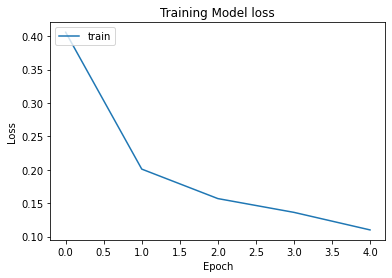

9
        date       Actual    Predicted
0  2018/5/21  2712.969971  2712.645043
1  2018/5/22  2733.010010  2705.785923
2  2018/5/23  2724.439941  2717.276041
3  2018/5/24  2733.290039  2722.926889
4  2018/5/25  2727.760010  2723.470770
5  2018/5/29  2721.330078  2724.976041
6  2018/5/30  2689.860107  2708.739323
7  2018/5/31  2724.010010  2707.840782
8   2018/6/1  2705.270020  2707.900246

-----Model Evaluation-----------------------------------------------------

1/1 - 0s - loss: 0.0959 - mean_squared_error: 0.0959
LSTM Model Loss =  [0.09587074816226959, 0.09587074816226959]
Model Accuracy =  99.62954576129046
Mean Absolute Error =  10.076659810589515  degrees
Mean Squared Error =  172.93891671369246
Root Mean Squared Error =  13.150624194831684

--------------------------------------------------------------------------



In [92]:
hist, model, df_compare, Accuracy, MAE, MSE, RMSE = DP_LSTM(df)